In [4]:
import os
import sys
import math
import time
import numpy as np
from scipy.interpolate import CubicSpline
from numba import jit

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import animation, rc
from matplotlib.animation import PillowWriter
from IPython.display import HTML, Image

from MDAnalysis.coordinates.XYZ import XYZReader
import copy

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(170786)

rc('animation', html='html5')

# plt.rcParams["animation.html"] = "jshtml"
# plt.rcParams['figure.dpi'] = 150
# %matplotlib notebook
# %load_ext autoreload
# %autoreload 2
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300
# plt.style.use('ggplot')

In [5]:
def dist(a,b):
    return np.sqrt(np.sum(np.square(a-b)))

## String method for analytic 2D potentials

In [6]:
def string_method_2d(grad_potential, init_points, N, tol=None):
    a,b = init_points
    string = np.linspace(a, b, N+1, dtype=np.float32).T
    if tol is None:
        tol = max(N**(-4), 10**(-10))
    dt = 0.05*min(0.2, N**(-1))
    d = 100
#     print(tol)
    
    frames = []
    ds = []
    counter=0
    while d >= tol:
        
        # change the format of grad_potential parameters to generalize dimensions
        force = grad_potential(string[0], string[1]) 
        
        string_star = string - dt*force

        arcs = [0]
        for j in range(1, N+1):
            arcs.append(arcs[-1] + dist(string_star[:,j], string_star[:,j-1]))
        arcs = np.array(arcs)
        alpha_istars = arcs/arcs[-1]
    
        # funny business with multidimensional spline interpolations
#        phi_interpolate = CubicSpline(alpha_istars, string_star, bc_type='not-a-knot')
        # can separate because cartesian coordinates make a normal basis
        phi_interpolatex = CubicSpline(alpha_istars, string_star[0], bc_type='not-a-knot')
        phi_interpolatey = CubicSpline(alpha_istars, string_star[1], bc_type='not-a-knot')
        
        # alpha
        alpha_is = np.arange(0, N+1, 1, dtype=np.float32)/N
        new_string = np.array([phi_interpolatex(alpha_is), phi_interpolatey(alpha_is)])

        
        distances = np.array([dist(new_string[:,i], string[:,i]) for i in range(N+1)], dtype=np.float32)
        d = 1/dt*max(distances)
        ds.append(d)
        print(counter, d)

        string=new_string
        counter+=1
        frames.append(string)
        #if counter>500: break
    return string, np.array(frames), np.array(ds)

### Examples
Example 1: Weinan E, Ren, and Vanden-Eijnden illustrative example

In [7]:
# Weinan E, Ren, and Vanden-Eijnden illustrative example potential and grad
def test_potential_1(x, y):
    return (1-x**2-y**2)**2 + y**2 / (x**2 + y**2)

def test_grad_potential_1(x, y):
    r = x**2 + y**2
    partial_x = 2*x*(y**2*(2-r**-2)+2*x**2 - 2)
    partial_y = 2*y*(y**2*(2-r**-2) + 1/r + 2*x**2 - 2)
    return np.array([partial_x, partial_y])
 

<a list of 77 text.Text objects>

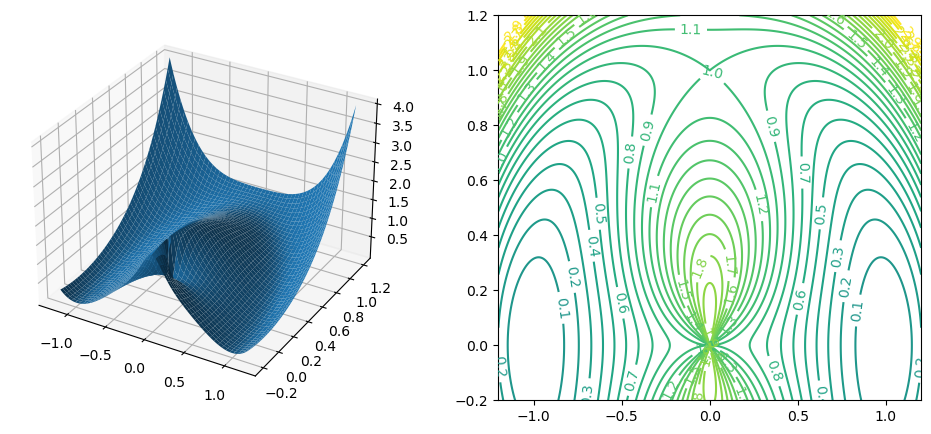

In [8]:
X = np.linspace(-1.2,1.2,1000)
Y = np.linspace(-0.2,1.2,1000)
X, Y = np.meshgrid(X,Y)
V = test_potential_1(X,Y)
 
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)
 
ax1.plot_surface(X,Y,V)
levels = np.arange(-3, 3, 0.1)
CS = ax2.contour(X,Y,V, levels)
ax2.clabel(CS, inline=1)


In [ ]:
# ZTS Run
rt_0 = time.time()
final_test_string, test_frames, test_ds = string_method_2d(test_grad_potential_1, [(-0.5, 0.5),(0.5,0.5)], 75)
rt_f = time.time()
print('runtime: %f s' % (rt_f - rt_0))

Text(0.5, 0, 'N')

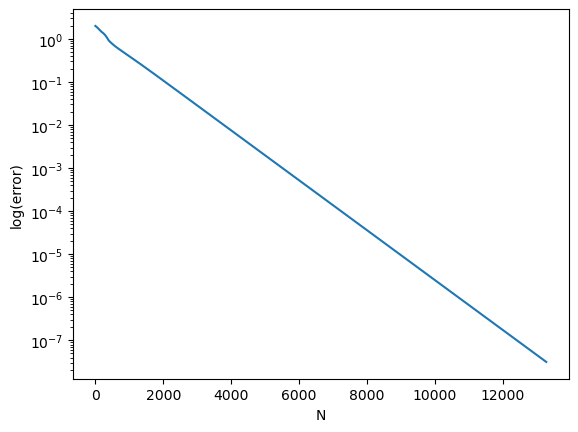

In [10]:
test_runs = len(test_ds)
runs = np.arange(0, test_runs, 1)
plt.plot(runs, test_ds)
plt.yscale("log")
plt.ylabel('log(error)')
plt.xlabel('N')

13278


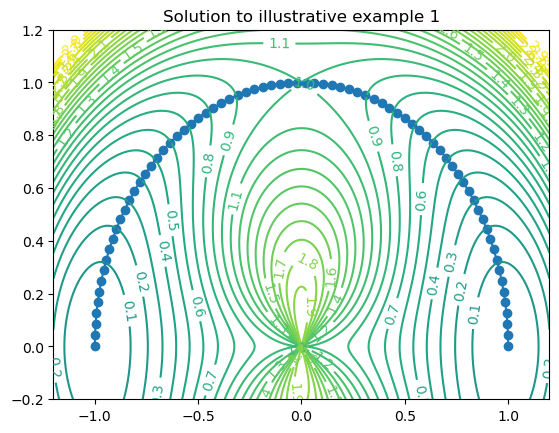

In [11]:
X = np.linspace(-1.2,1.2,1000)
Y = np.linspace(-0.2,1.2,1000)
X, Y = np.meshgrid(X,Y)
V = test_potential_1(X,Y)

levels1 = np.arange(-3, 3, 0.1)
CS1 = plt.contour(X,Y,V, levels1)
plt.clabel(CS1, inline=1)
plt.plot(final_test_string[0], final_test_string[1])
plt.scatter(final_test_string[0], final_test_string[1])
plt.title('Solution to illustrative example 1')
print(len(test_frames))

Text(0.5, 1.0, 'Initial String')

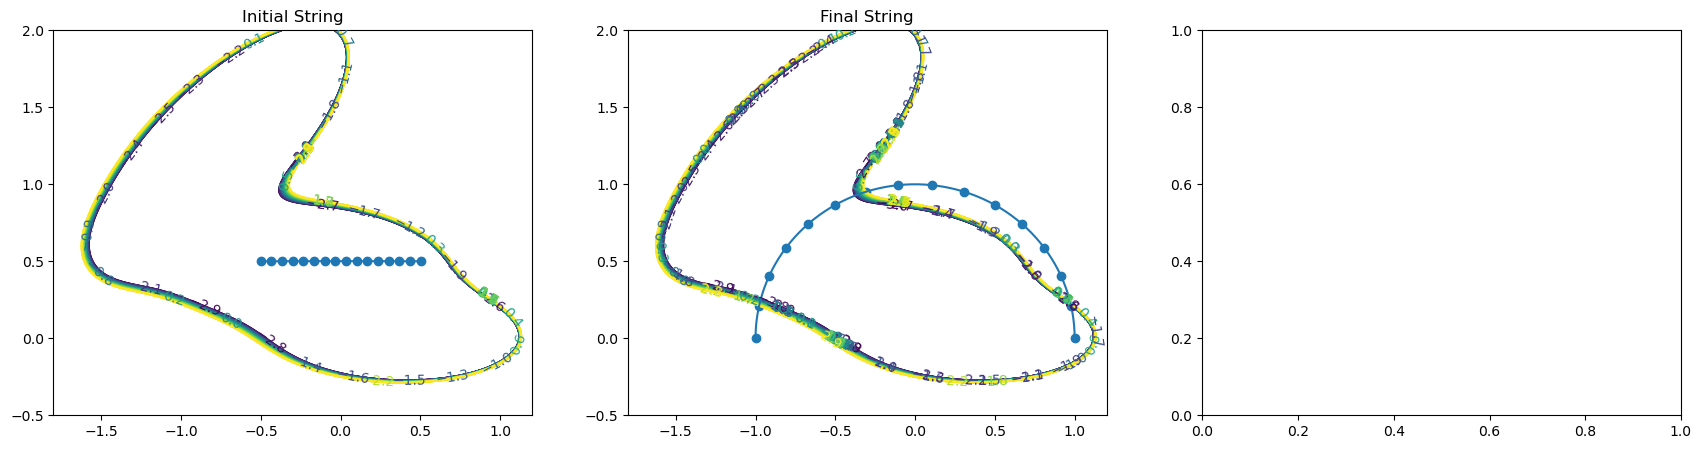

In [31]:
fig = plt.figure(figsize=(21,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
levels1 = np.arange(-3, 3, 0.1)
CS1 = ax2.contour(X,Y,V, levels1)
ax2.clabel(CS1, inline=1)
ax2.plot(final_test_string[0], final_test_string[1])
ax2.scatter(final_test_string[0,::5], final_test_string[1,::5])
ax2.clabel(CS1, inline=1)
ax2.set_title("Final String")

CS1 = ax1.contour(X,Y,V, levels1)
ax1.clabel(CS1, inline=1)
ax1.plot(test_frames[0,0],test_frames[0,1])
ax1.scatter(test_frames[0,0, ::5],test_frames[0,1,::5])
ax1.set_title("Initial String")


In [158]:
# Save soln as gif
plt.ioff()
fig, ax = plt.subplots()
import matplotlib
X = np.linspace(-1.2,1.2,1000)
Y = np.linspace(-0.2,1.2,1000)
X, Y = np.meshgrid(X,Y)
V = test_potential_1(X,Y)
levels = np.arange(-3, 3, 0.1)

def test_animate(t):
    ax.cla()
    CS1 = ax.contour(X,Y,V, levels1)
    ax.plot(test_frames[t, 0],test_frames[t, 1])
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-0.2, 1.2)

test_anim = matplotlib.animation.FuncAnimation(fig, test_animate, frames=np.arange(0, int(len(test_frames)/20), 30))
test_anim.save('./test_animation.gif', writer='Pillow', fps=60)

plt.close()

MovieWriter Pillow unavailable; using Pillow instead.


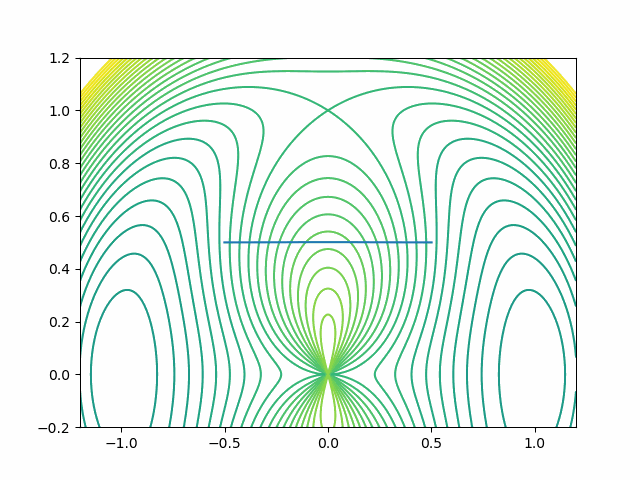

In [159]:
display(Image(data=open('./test_animation.gif','rb').read(), format='png'))

Example 2: Müller-Brown Potential

In [24]:
def Muller_brown_surface(x,y):

    A = np.array([-200, -100, -170, 15])
    a = np.array([-1,-1,-6.5,0.7])
    b = np.array([0,0,11,0.6])
    c = np.array([-10,-10,-6.5,0.7])
    x_0 = np.array([1,0,-.5,-1])
    y_0 = np.array([0,0.5,1.5,1])

    v = 0
    for k in range(4):
        xsub = (x-x_0[k])
        ysub = (y-y_0[k])
        v += A[k]*np.exp(a[k]*xsub**2 + b[k]*xsub*ysub + c[k]*ysub**2)
    
    return v

def grad_mullerbrown(x,y):
    
    A = np.array([-200, -100, -170, 15])
    a = np.array([-1,-1,-6.5,0.7])
    b = np.array([0,0,11,0.6])
    c = np.array([-10,-10,-6.5,0.7])
    x_0 = np.array([1,0,-.5,-1])
    y_0 = np.array([0,0.5,1.5,1])

    partialx = 0
    partialy = 0
    for k in range(4):
        xsub = (x-x_0[k])
        ysub = (y-y_0[k])
        v_comp = A[k]*np.exp(a[k]*xsub**2 + b[k]*xsub*ysub + c[k]*ysub**2)
        partialx += (2*a[k]*xsub + b[k]*ysub)*v_comp
        partialy += (b[k]*xsub + 2*c[k]*ysub)*v_comp
    
    return np.array([partialx, partialy])

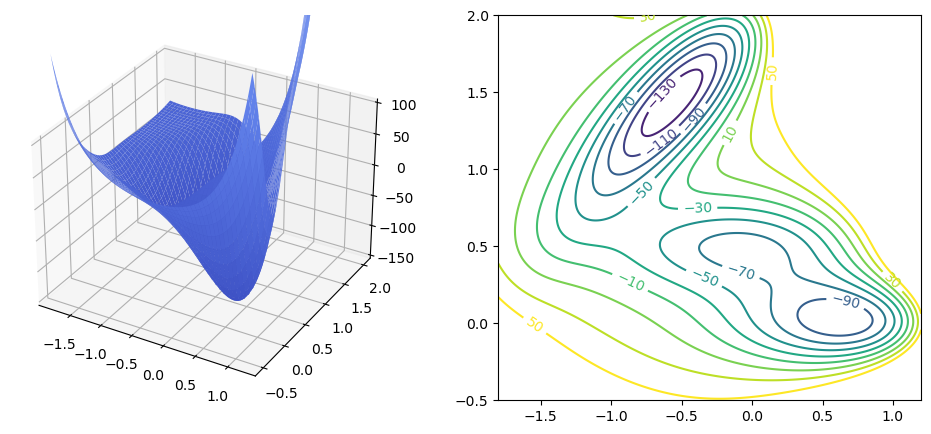

In [25]:
plt.close()
X = np.linspace(-1.8,1.2,1000)
Y = np.linspace(-0.5,2,1000)
X, Y = np.meshgrid(X,Y)
V = Muller_brown_surface(X,Y)
 
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)
 
ax1.plot_surface(X,Y,V, cmap=cm.coolwarm)
ax1.set_zlim(-150, 100)
levels = np.arange(-150, 70, 20)
CS = ax2.contour(X,Y,V, levels)
ax2.clabel(CS, inline=1)
plt.draw()
plt.show()

In [ ]:
rt_0 = time.time()
final_mullerbrown, mullerbrown_frames, mb_ds = string_method_2d(grad_mullerbrown, [(-1., 1.7),(0.5,0.0)], 200)
rt_f = time.time()
print('runtime: %f s' % (rt_f - rt_0))

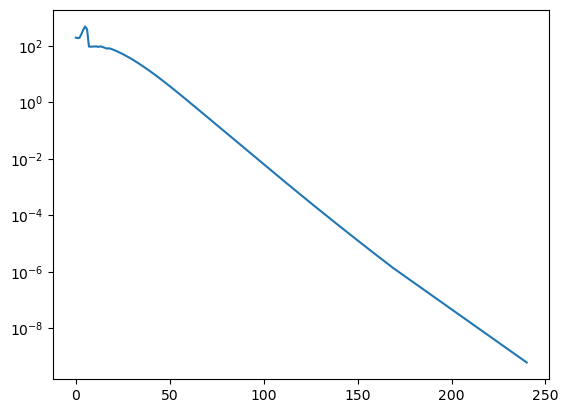

In [27]:
mb_runs = len(mb_ds)
runs = np.arange(0, mb_runs, 1)
plt.plot(runs, mb_ds)
plt.yscale("log")
plt.draw()
plt.show()

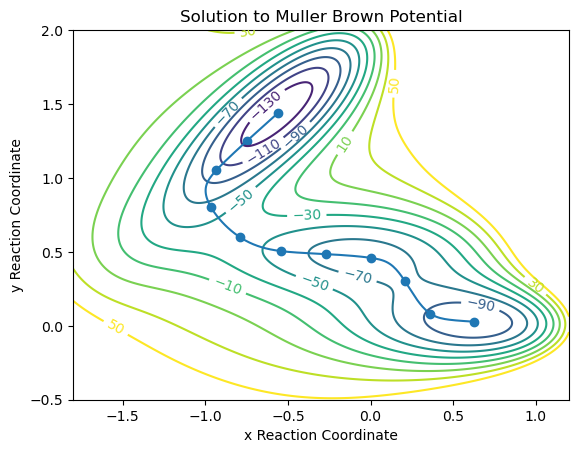

In [28]:
X = np.linspace(-1.8,1.2,1000)
Y = np.linspace(-0.5,2,1000)
X, Y = np.meshgrid(X,Y)
V = Muller_brown_surface(X,Y)

levels2 = np.arange(-150, 70, 20)
CS2 = plt.contour(X,Y,V, levels2)
plt.clabel(CS2, inline=1)
plt.plot(final_mullerbrown[0], final_mullerbrown[1])
plt.scatter(final_mullerbrown[0,::20], final_mullerbrown[1,::20])
plt.xlabel('x Reaction Coordinate')
plt.ylabel('y Reaction Coordinate')
plt.title('Solution to Muller Brown Potential')
plt.show()

Text(0.5, 1.0, 'Initial String')

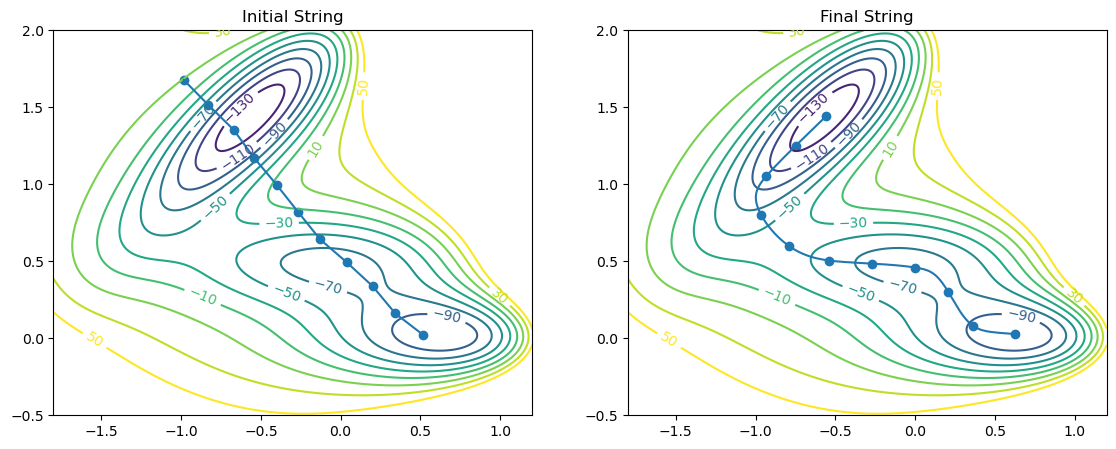

In [39]:
fig = plt.figure(figsize=(21,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)

levels2 = np.arange(-150, 70, 20)
CS2 = ax2.contour(X,Y,V, levels2)

ax2.plot(final_mullerbrown[0], final_mullerbrown[1])
ax2.scatter(final_mullerbrown[0,::20], final_mullerbrown[1,::20])
ax2.clabel(CS2, inline=1)
ax2.set_title("Final String")

CS2 = ax1.contour(X,Y,V, levels2)
ax1.clabel(CS2, inline=1)
ax1.plot(mullerbrown_frames[0,0,::20],mullerbrown_frames[0,1,::20])
ax1.scatter(mullerbrown_frames[0,0,::20],mullerbrown_frames[0,1,::20])
ax1.set_title("Initial String")



In [41]:
# Save soln as gif
plt.ioff()
fig, ax = plt.subplots()
import matplotlib
X = np.linspace(-1.8,1.2,1000)
Y = np.linspace(-0.5,2,1000)
X, Y = np.meshgrid(X,Y)
V = Muller_brown_surface(X,Y)
levels2 = np.arange(-150, 70, 10)

def test_animate(t):
    ax.cla()
    CS2 = ax.contour(X,Y,V, levels2)
    ax.plot(mullerbrown_frames[t, 0],mullerbrown_frames[t, 1])
    ax.set_xlim(-1.8,1.2)
    ax.set_ylim(-0.5,2)

test2_anim = matplotlib.animation.FuncAnimation(fig, test_animate, frames=np.arange(0, int(len(mullerbrown_frames)/2), 2))
test2_anim.save('./muller_animation.gif', writer='Pillow', fps=60)

plt.close()

MovieWriter Pillow unavailable; using Pillow instead.


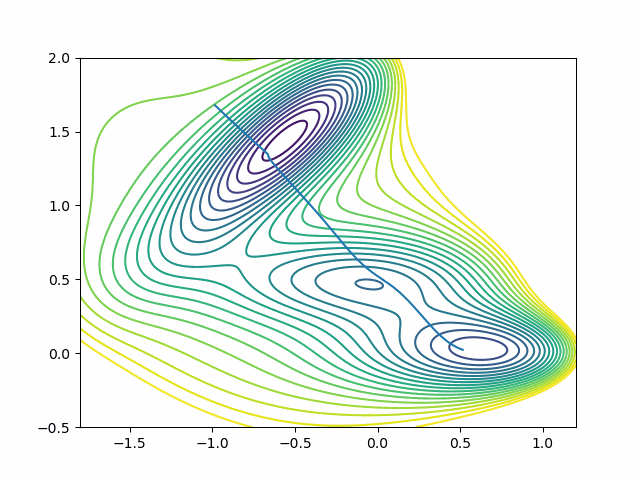

In [42]:
display(Image(data=open('./muller_animation.gif','rb').read(), format='png'))

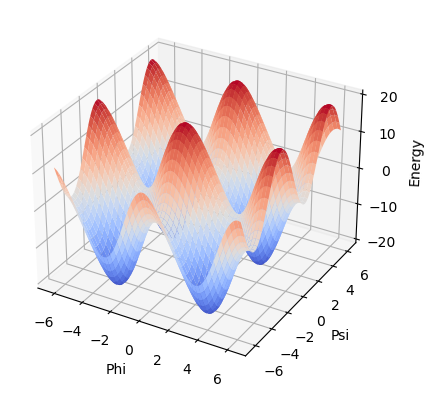

In [43]:


def dipeptide_potential(phi, psi, A=1, B=10, C=-10, D=-1):
    term1 = A * np.cos(psi)
    term2 = B * np.cos(phi)
    term3 = C * np.sin(psi)
    term4 = D * np.sin(2*phi)
    return term1 + term2 + term3 + term4

def dipeptide_gradient(phi, psi, A=1, B=10, C=-10, D=-1):
    dphi = -B * np.sin(phi) + 2*D * np.cos(2*phi)
    dpsi = -A * np.sin(psi) + C * np.cos(psi)
    return np.array([dphi, dpsi])

# Generate data for plotting the potential surface
phi = np.linspace(-2*np.pi, 2*np.pi, 1000)
psi = np.linspace(-2*np.pi, 2*np.pi, 1000)
PHI, PSI = np.meshgrid(phi, psi)
Z = dipeptide_potential(PHI, PSI)

# Plot the potential surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# levels = np.arange(-20, 20, 20)
# CS = plt.contour(PHI,PSI,Z, levels2)
# plt.clabel(CS, inline=1)
surf = ax.plot_surface(PHI, PSI, Z, cmap='coolwarm')
ax.set_xlabel('Phi')
ax.set_ylabel('Psi')
ax.set_zlabel('Energy')
#ax.set_title('Dipeptide Alignment Potential')
plt.show()

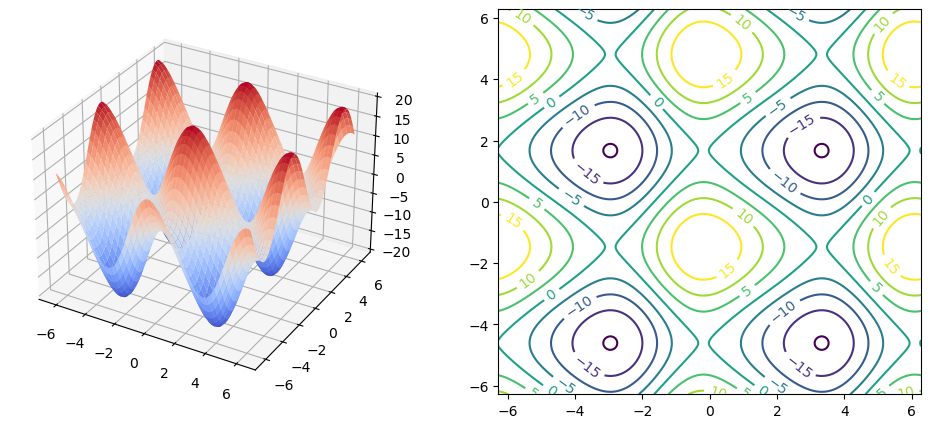

In [44]:

phi = np.linspace(-2*np.pi, 2*np.pi, 1000)
psi = np.linspace(-2*np.pi, 2*np.pi, 1000)
PHI, PSI = np.meshgrid(phi, psi)
Z = dipeptide_potential(PHI, PSI)

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

ax1.plot_surface(PHI,PSI,Z, cmap=cm.coolwarm)
ax1.set_zlim(-20, 20)
levels = np.arange(-20, 20, 5)
CS = ax2.contour(PHI,PSI,Z, levels)
ax2.clabel(CS, inline=1)
plt.draw()

plt.show()

In [ ]:
rt_0 = time.time()
rand_sol = string_method_2d(dipeptide_gradient, [(3, -3),(-3,3)], 200, tol=1e-4)
rt_f = time.time()
print('runtime: %f s' % (rt_f - rt_0))

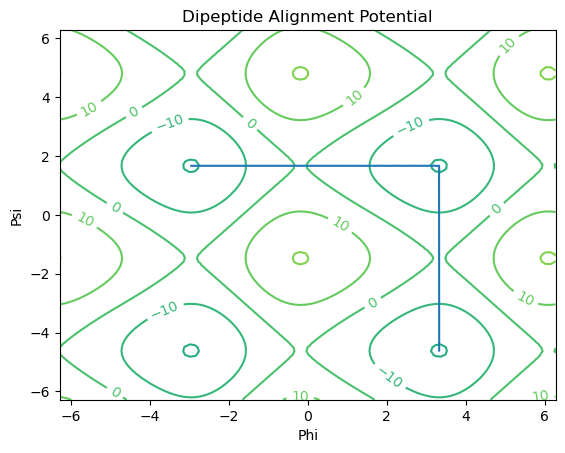

In [46]:
phi = np.linspace(-2*np.pi, 2*np.pi, 100)
psi = np.linspace(-2*np.pi, 2*np.pi, 100)
PHI, PSI = np.meshgrid(phi, psi)
Z = dipeptide_potential(PHI, PSI)

levels = np.arange(-20, 20, 20)
CS = plt.contour(PHI,PSI,Z, levels2)
plt.clabel(CS, inline=1)
plt.plot(rand_sol[0][0], rand_sol[0][1])
plt.xlabel('Phi')
plt.ylabel('Psi')
# ax.set_zlabel('Energy')
plt.title('Dipeptide Alignment Potential')
plt.show()

#lol chat gpt gradient prob wrong

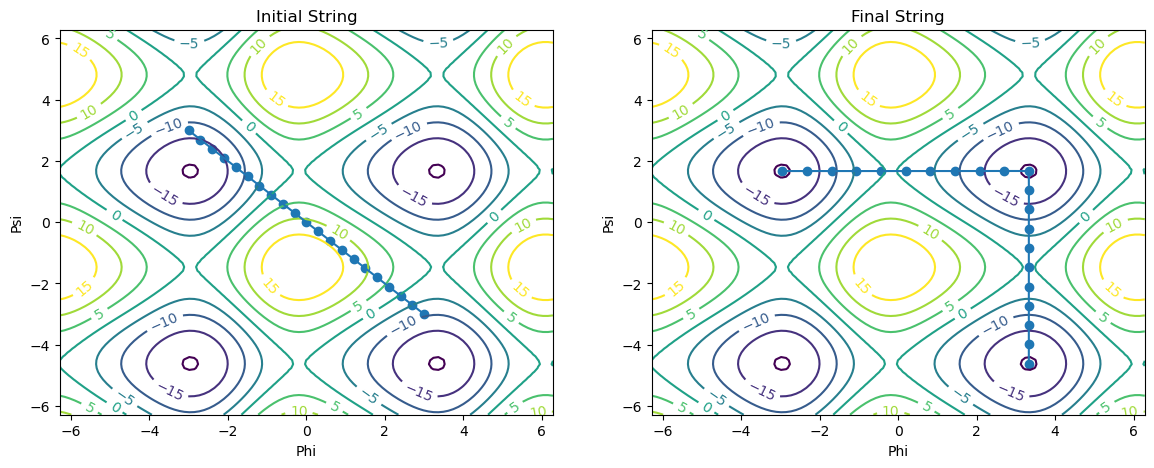

In [96]:
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

levels = np.arange(-20, 20, 5)
CS = ax1.contour(PHI,PSI,Z, levels)
ax1.clabel(CS, inline=1)
ax1.plot(rand_sol[1][0][0], rand_sol[1][0][1])
ax1.scatter(rand_sol[1][0][0,::10], rand_sol[1][0][1,::10])
ax1.set_title("Initial String")
ax1.set_xlabel("Phi")
ax1.set_ylabel("Psi")

CS = ax2.contour(PHI,PSI,Z, levels)
ax2.clabel(CS, inline=1)
ax2.plot(rand_sol[1][5000][0,::10], rand_sol[1][5000][1,::10])
ax2.scatter(rand_sol[1][5000][0,::10], rand_sol[1][5000][1,::10])
ax2.set_title("Final String")
ax2.set_xlabel("Phi")
ax2.set_ylabel("Psi")
plt.show()


In [ ]:
mb_runs = len(rand_sol[2])
runs = np.arange(0, mb_runs, 1)
plt.plot(runs, mb_ds)
plt.yscale("log")
plt.draw()
plt.show()

## String Method with Higher Dimensional Potential
#### Minimum Energy Path of Argon atom moving through 125 Ar atom liquid (LJ potential)

In [99]:
trajFile='Ar_liq_MC.xyz'
traj = XYZReader(trajFile)

xyz_traj = []
for frame in range(len(traj)):
    xyz_traj.append(np.array(copy.deepcopy(traj[frame].positions[:,:]))/10.) #Ang -> nm
xyz_traj = np.array(xyz_traj)
nFrames = len(xyz_traj)
N=xyz_traj[0].shape[0]
# print(nFrames)

In [100]:
def plot_config(xyz, L):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], zdir='z', s = 15, depthshade=True)
#     ax.scatter(xyz[30,0], xyz[30,1], xyz[30,2])
#     ax.scatter(0, 0, 0)
    ax.set_xlim([0,L])
    ax.set_ylim([0,L])
    ax.set_zlim([0,L])
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    plt.draw()
    plt.show()
    
    return None

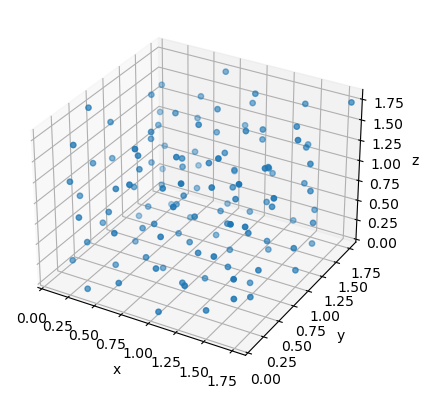

In [101]:
Ls = [2.35256775, 2.29073127, 2.18829343, 2.11864596, 2.06680909, 2.04974418,
 2.01616739, 1.98185927, 1.94088118, 1.92253743, 1.90887376, 1.91528815,
 1.89824706, 1.88437256, 1.91310228, 1.87222012, 1.88668835, 1.87887617,
 1.87564441, 1.87885715, 1.83939654, 1.82831102, 1.83595319, 1.8408789,
 1.83245414, 1.83825717, 1.83464098, 1.83832322, 1.82732627, 1.83883966,
 1.84295693, 1.85016722, 1.85000764, 1.85196374, 1.83936563, 1.83666743,
 1.8323653,  1.81955109, 1.82256624, 1.8145722,  1.81473886, 1.8085208,
 1.80421093, 1.80300056, 1.82015139, 1.81822719, 1.81666049, 1.82717098,
 1.82477328, 1.82914594, 1.814161,   1.814161,   1.81985076, 1.81985076,
 1.82849219, 1.80925875, 1.81298525, 1.83220051, 1.81209462, 1.81711937,
 1.81059333, 1.80867483, 1.80907934, 1.80907934, 1.81430902, 1.80231243,
 1.80438027, 1.81383788, 1.80316065, 1.79644912, 1.81668519, 1.80763621,
 1.80654518, 1.80079132, 1.8056709,  1.82370377, 1.81776947, 1.80253571,
 1.80110078, 1.80328942, 1.80200234, 1.80200234, 1.80999827, 1.81123345,
 1.81422873, 1.81590273, 1.82508102, 1.82387046, 1.82609966, 1.83952649,
 1.81871555, 1.81806926, 1.80752408, 1.8080858,  1.80943352, 1.81665952,
 1.82898209, 1.81312581, 1.81392535, 1.82807788]
plot_config(xyz_traj[49], Ls[49])

In [102]:
@jit
def r_ij(ri, rj, L):
    dr = rj - ri
    halfL = L/2.

    for i in range(3):
        if dr[i] >= halfL:
            dr[i] -= L
        elif dr[i] < -halfL:
            dr[i] += L

    return dr
@jit
def dist(a,b):
    return np.sqrt(np.sum(np.square(a-b)))

@jit
def f_ij(r,sigma,epsilon):
    s = np.sqrt(np.sum(np.square(r))) # r is rij
    usub = sigma/s
    f_mag = (-48*epsilon/s**2)*(usub**12 - 0.5*usub**6)

    return f_mag*r

@jit
def f_i(string,xyz,L,sigma,epsilon):
    
    fi_sums = np.zeros(string.shape)
    
    for (i, ri) in enumerate(np.transpose(string)):
        for rj in xyz:
            rij = r_ij(ri, rj, L)
            fi_sums[:,i] += f_ij(rij, sigma, epsilon)
    
    return fi_sums

@jit
def arclength_repram(string_star, imgN):
    arcs = [0]
    for j in range(1, imgN+1):
        arcs.append(arcs[-1] + dist(string_star[:,j], string_star[:,j-1]))
    arcs = np.array(arcs)
    alpha_istars = arcs/arcs[-1]
                
    return alpha_istars

@jit
def max_distance(new_string, string, imgN):
    max_dist = dist(new_string[:,0],string[:,0])
    for i in range(1, imgN+1):
        dist_i = dist(new_string[:,i], string[:,i])
        if dist_i > max_dist:
            max_dist = dist_i
    return max_dist

In [103]:
def string_method_ar(f_i, xyz, L, sigma, epsilon, init_points, imgN, dim=3):
    a,b = init_points
    string = np.linspace(a, b, imgN+1, dtype=np.float32).T
    tol = max(imgN**(-4), 10**(-10)) #too low for this system
    dt = 0.05*min(0.2, imgN**(-1))
    d = 100
    
    alpha_is = np.arange(0, imgN+1, 1, dtype=np.float32)/imgN
    frames = []
    ds = []
    counter=0
    while d >= tol:
        
        # f_i is the negative gradient wrt position of potential of all argon atoms
        string_forces = f_i(string, xyz, L, sigma, epsilon)
        
        # update string
        string_star = string + dt*string_forces*5e-8

        # revert updates to initial and final string image to fix end points?
#         string_star[:,0]=string[:,0]
#         string_star[:,-1]=string[:,-1]
        
        alpha_istars=arclength_repram(string_star, imgN)
    
        new_string = []
        for i in range(dim):
            phi_interpolate_i = CubicSpline(alpha_istars, string_star[i], bc_type='not-a-knot')
            new_string.append(phi_interpolate_i(alpha_is))
        
        new_string = np.array(new_string)

        max_dist=max_distance(new_string, string, imgN)
        d = 1/dt*max_dist
        ds.append(d)
        print(counter, d)
        
        frames.append(string)
        string=new_string
        counter+=1
        
        
        if counter > 4000:
            break
        
    return string, np.array(frames), np.array(ds)

In [ ]:
sigma=0.34 #nm
epsilon=1.65 #zJ
L = Ls[60]
xyz = xyz_traj[60]
init_points=[(0, 0.25, 0.1), (.9*L, .9*L, .9*L)] #nm

rt_0 = time.time()
Liq_ar_test = string_method_ar(f_i, xyz, L, sigma, epsilon, init_points, 300, dim=3)
rt_f = time.time()
print('runtime: %f s' % (rt_f - rt_0))

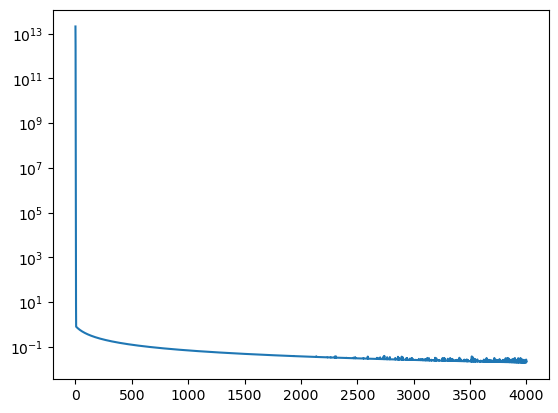

In [124]:
liq_ar_ds = Liq_ar_test[2]
plt.plot(list(range(len(liq_ar_ds))), liq_ar_ds)
plt.yscale("log")
plt.show()

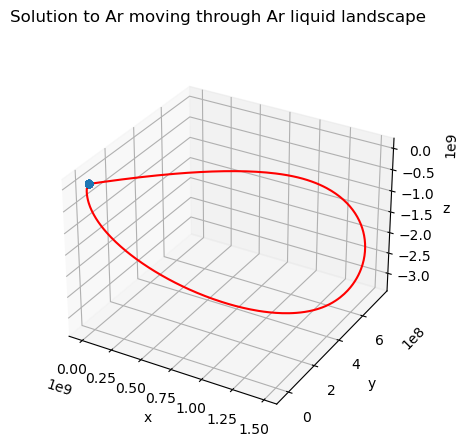

In [ ]:
%matplotlib inline
solx, soly, solz = Liq_ar_test[0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], s = 25)
# ax.scatter(xyz[70,0], xyz[70,1], xyz[70,2], s = 25)
ax.plot(solx, soly, solz, '-r')
ax.scatter(solx[0], soly[0], solz[0], color='r')
ax.scatter(solx[-1], soly[-1], solz[-1], color='r')

# ax.set_xlim([0,L])
# ax.set_ylim([0,L])
# ax.set_zlim([0,L])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
fig.suptitle('Solution to Ar moving through Ar liquid landscape')
plt.draw()
plt.show()

In [ ]:
def min_dist(r1,r2,L):
    halfL = L/2.
    dx = r2[0]-r1[0]
    dy = r2[1]-r1[1]
    dz = r2[2]-r1[2]
    if dx >= halfL:
        dx -= L
    elif dx < -halfL:
        dx += L
    if dy >= halfL:
        dy -= L
    elif dy < -halfL:
        dy += L
    if dz >= halfL:
        dz -= L
    elif dz < -halfL:
        dz += L

    return math.sqrt(dx**2+dy**2+dz**2)

def E_ij(s,sigma,epsilon):
    usub = sigma/s
    energy = 4*epsilon*(usub**12 - usub**6)
    return energy

def E_i(r,xyz,L,sigma,epsilon):
    
    Ei_sum = 0
    for (j, particle) in enumerate(xyz):
        s = min_dist(r, particle, L)
        Eij = E_ij(s, sigma, epsilon)
#         print(j, s, Eij)
        Ei_sum += Eij
    return Ei_sum

# for imgs in 

solution = Liq_ar_test[0]
soln_frames = Liq_ar_test[1]

sol_Es = []
rxn_coordinate = []
for j, img in enumerate(solution.T):
    sol_Es.append(E_i(img, xyz, L, sigma, epsilon))
    rxn_coordinate.append(j)
sol_Es = np.array(sol_Es)

Text(0.5, 0, 'Solution Coordinate')

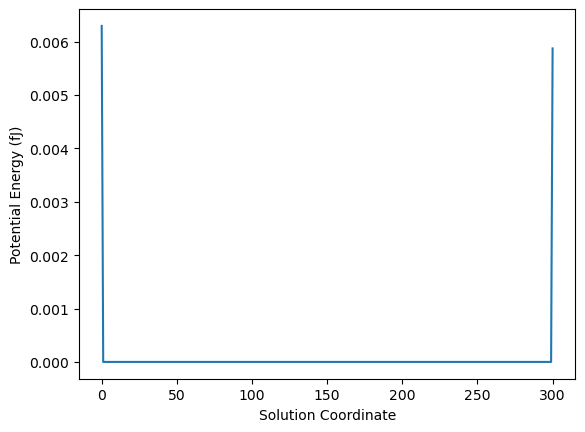

In [ ]:
%matplotlib inline
plt.plot(rxn_coordinate, sol_Es*1e-6)
plt.ylabel('Potential Energy (fJ)')
plt.xlabel('Solution Coordinate')

Text(0.5, 0, 'String Coordinate')

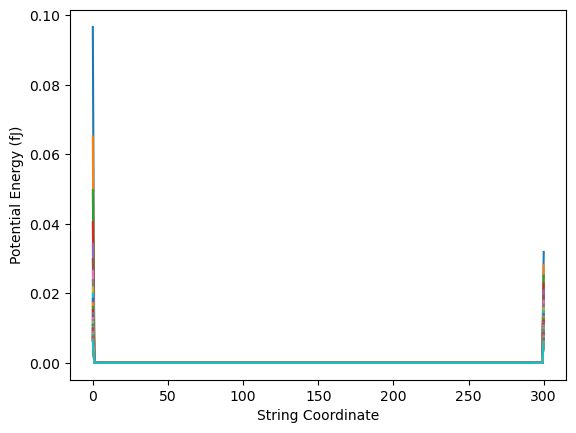

In [ ]:
soln_frames = Liq_ar_test[1]

for i, string in enumerate(soln_frames[100::100]):
    sol_Es = []
    rxn_coordinate = []
    for j, img in enumerate(string.T):
        sol_Es.append(1e-6*E_i(img, xyz, L, sigma, epsilon))
        rxn_coordinate.append(j)
    plt.plot(rxn_coordinate, sol_Es)
plt.ylabel('Potential Energy (fJ)')
plt.xlabel('String Coordinate')